# Exploration and Modeling of 2013 NYC Taxi Trip and Fare Dataset on Spark 2.0 HDInsight Clusters (pySpark3)

### Last updated:
Jan 08, 2016

---------------------------------
### Here we show some features and capabilities of Spark's MLlib toolkit using the NYC taxi trip and fare data-set from 2013 (about 40 Gb uncompressed). We take a 0.1% sample of this data-set (about 170K rows, 35 Mb) to to show MLlib's modeling features for binary classification and regression problems using this data-set. We have shown relevant plots in Python.

### We have sampled the data in order for the runs to finish quickly. The same code will on the full data-set.

----------------------------------

### OBJECTIVE: Show use of Spark MLlib's functions for featurization and ML tasks.

### We address two learning problems:
#### 1. Binary classification: Prediction of tip or no-tip (1/0) for a taxi trip [Using regularized regression]
#### 2. Regression problem: Prediction of the tip amonut ($) [Using random forest]

#### We have shown the following steps:
1. Data ingestion & cleanup
2. Data exploration and plotting
3. Data preparation (featurizing/transformation), 
4. Modeling (using incl. hyperparameter tuning with cross-validation), prediction, model persistance
5. Model evaluation on an independent validation data-set.

### Introductory material

NYC 2013 Taxi data:
http://www.andresmh.com/nyctaxitrips/
https://azure.microsoft.com/en-us/documentation/articles/machine-learning-data-science-process-hive-walkthrough/

An earlier version of this walkthrough was published in a set of notebooks to run on Spark 1.6 HDInsight clusters: https://docs.microsoft.com/en-us/azure/machine-learning/machine-learning-data-science-spark-overview

----------------------------------

## Set directory paths and location of training, validation files, as well as model location in blob storage
NOTE: The blob storage attached to the HDI cluster is referenced as: wasb:/// (Windows Azure Storage Blob). Other blob storage accounts are referenced as: wasb://

In [1]:
# 1. Location of training data
taxi_train_file_loc = "wasb://mllibwalkthroughs@cdspsparksamples.blob.core.windows.net/Data/NYCTaxi/JoinedTaxiTripFare.Point1Pct.Train.csv"
taxi_valid_file_loc = "wasb://mllibwalkthroughs@cdspsparksamples.blob.core.windows.net/Data/NYCTaxi/JoinedTaxiTripFare.Point1Pct.Valid.csv"

# 2. Set model storage directory path. This is where models will be saved.
modelDir = "wasb:///user/remoteuser/NYCTaxi/Models/"; # The last backslash is needed;

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
2,application_1486337199878_0019,pyspark3,idle,Link,Link,✔


SparkSession available as 'spark'.


## Set SQL context and import necessary libraries

In [2]:
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import numpy as np
import datetime

sqlContext = SQLContext(sc)

<a name="ingestion"></a>
## Data ingestion & cleanup: Read in joined 0.1% taxi trip and fare file (as csv), format and clean data, and create data-frame

The taxi trip and fare files were joined based on the instructions provided in: 
"https://azure.microsoft.com/en-us/documentation/articles/machine-learning-data-science-process-hive-walkthrough/"

A 0.1% sample of the joined data-set was taken to show the ML examples in this walkthrough.

In [3]:
## READ IN DATA FRAME FROM CSV
taxi_train_df = spark.read.csv(path=taxi_train_file_loc, header=True, inferSchema=True)

## CREATE A CLEANED DATA-FRAME BY DROPPING SOME UN-NECESSARY COLUMNS & FILTERING FOR UNDESIRED VALUES OR OUTLIERS
taxi_df_train_cleaned = taxi_train_df.drop('medallion').drop('hack_license').drop('store_and_fwd_flag').drop('pickup_datetime')\
    .drop('dropoff_datetime').drop('pickup_longitude').drop('pickup_latitude').drop('dropoff_latitude')\
    .drop('dropoff_longitude').drop('tip_class').drop('total_amount').drop('tolls_amount').drop('mta_tax')\
    .drop('direct_distance').drop('surcharge')\
    .filter("passenger_count > 0 and passenger_count < 8 AND payment_type in ('CSH', 'CRD') AND tip_amount >= 0 AND tip_amount < 30 AND fare_amount >= 1 AND fare_amount < 150 AND trip_distance > 0 AND trip_distance < 100 AND trip_time_in_secs > 30 AND trip_time_in_secs < 7200" )

## REGISTER DATA-FRAME AS A TEMP-TABLE IN SQL-CONTEXT
taxi_df_train_cleaned.createOrReplaceTempView("taxi_train")

<a name="exploration"></a>
## Data exploration & visualization: Plotting of target variables and features

#### First, summarize data using SQL, this outputs a Spark data frame. If the data-set is too large, it can be sampled

In [4]:
%%sql -q -o sqlResultsPD
SELECT fare_amount, passenger_count, tip_amount, tipped FROM taxi_train WHERE passenger_count > 0 AND passenger_count < 7 AND fare_amount > 0 AND fare_amount < 200 AND payment_type in ('CSH', 'CRD') AND tip_amount > 0 AND tip_amount < 25

#### Plot histogram of tip amount, relationship between tip amount vs. other features

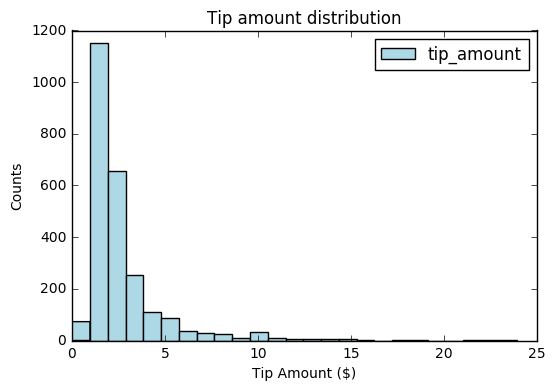

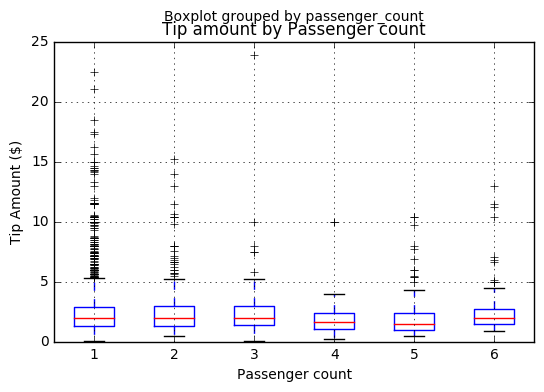

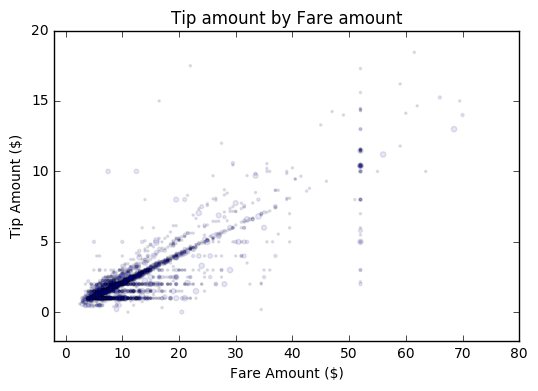

In [5]:
%%local
import matplotlib.pyplot as plt
%matplotlib inline
## %%local creates a pandas data-frame on the head node memory, from spark data-frame, 
## which can then be used for plotting. Here, sampling data is a good idea, depending on the memory of the head node

# TIP BY PAYMENT TYPE AND PASSENGER COUNT
ax1 = sqlResultsPD[['tip_amount']].plot(kind='hist', bins=25, facecolor='lightblue')
ax1.set_title('Tip amount distribution')
ax1.set_xlabel('Tip Amount ($)'); ax1.set_ylabel('Counts');
plt.figure(figsize=(4,4)); plt.suptitle(''); plt.show()

# TIP BY PASSENGER COUNT
ax2 = sqlResultsPD.boxplot(column=['tip_amount'], by=['passenger_count'])
ax2.set_title('Tip amount by Passenger count')
ax2.set_xlabel('Passenger count'); ax2.set_ylabel('Tip Amount ($)');
plt.figure(figsize=(4,4)); plt.suptitle(''); plt.show()

# TIP AMOUNT BY FARE AMOUNT, POINTS ARE SCALED BY PASSENGER COUNT
ax = sqlResultsPD.plot(kind='scatter', x= 'fare_amount', y = 'tip_amount', c='blue', alpha = 0.10, s=2.5*(sqlResultsPD.passenger_count))
ax.set_title('Tip amount by Fare amount')
ax.set_xlabel('Fare Amount ($)'); ax.set_ylabel('Tip Amount ($)');
plt.axis([-2, 80, -2, 20])
plt.figure(figsize=(4,4)); plt.suptitle(''); plt.show()

<a name="transformation"></a>
## Feature engineering, transformation and data preparation for modeling

#### Create a new feature by binning hours into traffic time buckets using Spark SQL

In [6]:
### CREATE FOUR BUCKETS FOR TRAFFIC TIMES
sqlStatement = """ SELECT *, CASE
     WHEN (pickup_hour <= 6 OR pickup_hour >= 20) THEN "Night" 
     WHEN (pickup_hour >= 7 AND pickup_hour <= 10) THEN "AMRush" 
     WHEN (pickup_hour >= 11 AND pickup_hour <= 15) THEN "Afternoon"
     WHEN (pickup_hour >= 16 AND pickup_hour <= 19) THEN "PMRush"
    END as TrafficTimeBins
    FROM taxi_train 
"""
taxi_df_train_with_newFeatures = spark.sql(sqlStatement)

#### Indexing and one-hot encoding of categorical features
Here we only transform some variables to show examples, which are character strings. Other variables, such as week-day, which are represented by numerical valies, can also be indexed as categorical variables.

For indexing, we used stringIndexer, and for one-hot encoding, we used OneHotEncoder functions from MLlib.

In [7]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer

# DEFINE THE TRANSFORMATIONS THAT NEEDS TO BE APPLIED TO SOME OF THE FEATURES
sI1 = StringIndexer(inputCol="vendor_id", outputCol="vendorIndex"); en1 = OneHotEncoder(dropLast=False, inputCol="vendorIndex", outputCol="vendorVec");
sI2 = StringIndexer(inputCol="rate_code", outputCol="rateIndex"); en2 = OneHotEncoder(dropLast=False, inputCol="rateIndex", outputCol="rateVec");
sI3 = StringIndexer(inputCol="payment_type", outputCol="paymentIndex"); en3 = OneHotEncoder(dropLast=False, inputCol="paymentIndex", outputCol="paymentVec");
sI4 = StringIndexer(inputCol="TrafficTimeBins", outputCol="TrafficTimeBinsIndex"); en4 = OneHotEncoder(dropLast=False, inputCol="TrafficTimeBinsIndex", outputCol="TrafficTimeBinsVec");

# APPLY TRANSFORMATIONS
encodedFinal = Pipeline(stages=[sI1, en1, sI2, en2, sI3, en3, sI4, en4]).fit(taxi_df_train_with_newFeatures).transform(taxi_df_train_with_newFeatures);

#### Create a random sampling of the data, as needed (50% is used here). This can save some time while training models. Then, split into train/test.

In [8]:
trainingFraction = 0.5; testingFraction = (1-trainingFraction);
seed = 1234;
encodedFinalSampled = encodedFinal.sample(False, 0.5, seed=seed)

# SPLIT SAMPLED DATA-FRAME INTO TRAIN/TEST, WITH A RANDOM COLUMN ADDED FOR DOING CV (SHOWN LATER)
trainData, testData = encodedFinalSampled.randomSplit([trainingFraction, testingFraction], seed=seed);

# CACHE DATA FRAMES IN MEMORY
trainData.cache(); trainData.count();
testData.cache(); testData.count();

31492

## Binary classification model training: Predicting tip or no tip (target: tipped = 1/0)

### Create logistic regression model, save modle, and evaluate performance of model on test data set

#### Create  logistic regression model using RFormula and LogisticRegression functions

In [9]:
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.feature import RFormula
from sklearn.metrics import roc_curve,auc

## TRAIN USING PIPELINE FORMULA + LOGISTIC REGRESSION ESTIMATOR
logReg = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

## DEFINE TRAINING FORMULA
classFormula = RFormula(formula="tipped ~ pickup_hour + weekday + passenger_count + trip_time_in_secs + trip_distance + fare_amount + vendorVec + paymentVec + rateVec + TrafficTimeBinsVec")

## TRAIN PIPELINE MODEL
model = Pipeline(stages=[classFormula, logReg]).fit(trainData)

## SAVE MODEL
datestamp = datetime.datetime.now().strftime('%m-%d-%Y-%s');
fileName = "logisticRegModel_" + datestamp;
logRegDirfilename = modelDir + fileName;
model.save(logRegDirfilename)

## PREDICT ON TEST DATA AND EVALUATE
predictions = model.transform(testData)
predictionAndLabels = predictions.select("label","prediction").rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

## REGISTER PREDICTION RESULTS TABLE
predictions.select("label","probability").createOrReplaceTempView("tmp_results");

Area under ROC = 0.9859906352003691

#### Plot ROC curve from prediction result on test data

In [10]:
%%sql -q -o predictions_pddf -m sample -r 0.5 -n -1
SELECT * from tmp_results

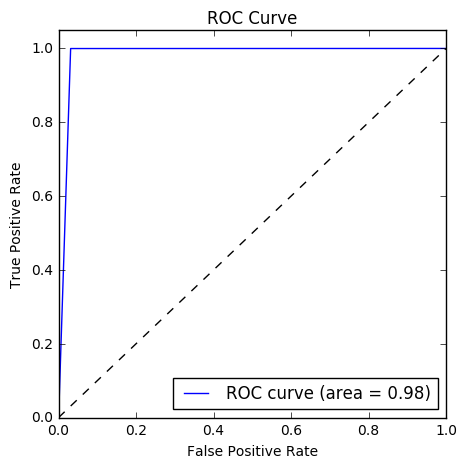

In [11]:
%%local
## PLOT ROC CURVE AFTER CONVERTING PREDICTIONS TO A PANDAS DATA FRAME
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
%matplotlib inline

labels = predictions_pddf["label"]
prob = []
for dv in predictions_pddf["probability"]:
    prob.append(list(dv.values())[1][1])
    
fpr, tpr, thresholds = roc_curve(labels, prob, pos_label=1);
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate');
plt.title('ROC Curve'); plt.legend(loc="lower right");
plt.show()

## Train a regression model: Predict the amount of tip paid for taxi trips

### Train a random forest regression model using the Pipeline function, save, and evaluate on test data set

In [12]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.mllib.evaluation import RegressionMetrics

## DEFINE REGRESSION FURMULA
regFormula = RFormula(formula="tip_amount ~ paymentIndex + vendorIndex + rateIndex + TrafficTimeBinsIndex + pickup_hour + weekday + passenger_count + trip_time_in_secs + trip_distance + fare_amount")

## DEFINE INDEXER FOR CATEGORIAL VARIABLES
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=32)

## DEFINE RANDOM FOREST ESTIMATOR
randForest = RandomForestRegressor(featuresCol = 'indexedFeatures', labelCol = 'label', numTrees=20, 
                                   featureSubsetStrategy="auto",impurity='variance', maxDepth=6, maxBins=100)

## Fit model, with formula and other transformations
model = Pipeline(stages=[regFormula, featureIndexer, randForest]).fit(trainData)

## SAVE MODEL
datestamp = datetime.datetime.now().strftime('%m-%d-%Y-%s');
fileName = "RandomForestRegressionModel_" + datestamp;
randForestDirfilename = modelDir + fileName;
model.save(randForestDirfilename)

## PREDICT ON TEST DATA AND EVALUATE
predictions = model.transform(testData)
predictionAndLabels = predictions.select("label","prediction").rdd
testMetrics = RegressionMetrics(predictionAndLabels)
print("RMSE = %s" % testMetrics.rootMeanSquaredError)
print("R-sqr = %s" % testMetrics.r2)

## PLOC ACTUALS VS. PREDICTIONS
predictions.select("label","prediction").createOrReplaceTempView("tmp_results");

RMSE = 0.9727897248904693
R-sqr = 0.6789564803667094

In [13]:
%%sql -q -o predictionsPD
SELECT * from tmp_results

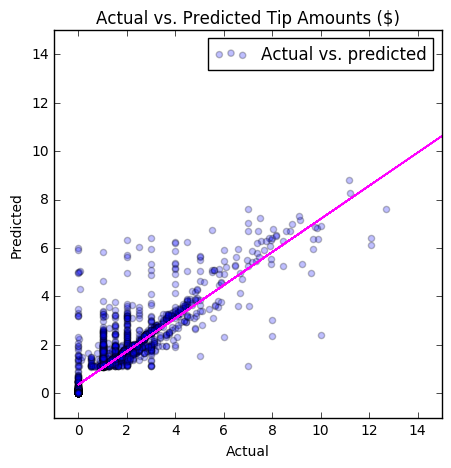

In [14]:
%%local
import numpy as np

ax = predictionsPD.plot(kind='scatter', figsize = (5,5), x='label', y='prediction', color='blue', alpha = 0.25, label='Actual vs. predicted');
fit = np.polyfit(predictionsPD['label'], predictionsPD['prediction'], deg=1)
ax.set_title('Actual vs. Predicted Tip Amounts ($)')
ax.set_xlabel("Actual"); ax.set_ylabel("Predicted");
ax.plot(predictionsPD['label'], fit[0] * predictionsPD['label'] + fit[1], color='magenta')
plt.axis([-1, 15, -1, 15])
plt.show(ax)

## Load a saved pipeline model and evaluate it on test data set

In [15]:
from pyspark.ml import PipelineModel

savedModel = PipelineModel.load(logRegDirfilename)

predictions = savedModel.transform(testData)
predictionAndLabels = predictions.select("label","prediction").rdd

metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under ROC = 0.9859906352003691

## Hyper-parameter tuning: Train a random forest model using cross-validation

In [16]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

## DEFINE RANDOM FOREST MODELS
randForest = RandomForestRegressor(featuresCol = 'indexedFeatures', labelCol = 'label', 
                                   featureSubsetStrategy="auto",impurity='variance', maxBins=100)

## DEFINE MODELING PIPELINE, INCLUDING FORMULA, FEATURE TRANSFORMATIONS, AND ESTIMATOR
pipeline = Pipeline(stages=[regFormula, featureIndexer, randForest])

## DEFINE PARAMETER GRID FOR RANDOM FOREST
paramGrid = ParamGridBuilder() \
    .addGrid(randForest.numTrees, [10, 25, 50]) \
    .addGrid(randForest.numTrees, [3, 5, 7]) \
    .build()

## DEFINE CROSS VALIDATION
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(metricName="rmse"),
                          numFolds=3)

## TRAIN MODEL USING CV
cvModel = crossval.fit(trainData)

## PREDICT AND EVALUATE TEST DATA SET
predictions = cvModel.transform(testData)
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print("R-squared on test data = %g" % r2)

## SAVE THE BEST MODEL
datestamp = datetime.datetime.now().strftime('%m-%d-%Y-%s');
fileName = "CV_RandomForestRegressionModel_" + datestamp;
CVDirfilename = modelDir + fileName;
cvModel.bestModel.save(CVDirfilename);

R-squared on test data = 0.770073

## Load and transform an independent validation data-set, and evaluate the saved pipeline model

In [17]:
## READ IN DATA FRAME FROM CSV
taxi_valid_df = spark.read.csv(path=taxi_valid_file_loc, header=True, inferSchema=True)

## CREATE A CLEANED DATA-FRAME BY DROPPING SOME UN-NECESSARY COLUMNS & FILTERING FOR UNDESIRED VALUES OR OUTLIERS
taxi_df_valid_cleaned = taxi_valid_df.drop('medallion').drop('hack_license').drop('store_and_fwd_flag').drop('pickup_datetime')\
    .drop('dropoff_datetime').drop('pickup_longitude').drop('pickup_latitude').drop('dropoff_latitude')\
    .drop('dropoff_longitude').drop('tip_class').drop('total_amount').drop('tolls_amount').drop('mta_tax')\
    .drop('direct_distance').drop('surcharge')\
    .filter("passenger_count > 0 and passenger_count < 8 AND payment_type in ('CSH', 'CRD') AND tip_amount >= 0 AND tip_amount < 30 AND fare_amount >= 1 AND fare_amount < 150 AND trip_distance > 0 AND trip_distance < 100 AND trip_time_in_secs > 30 AND trip_time_in_secs < 7200" )

## REGISTER DATA-FRAME AS A TEMP-TABLE IN SQL-CONTEXT
taxi_df_valid_cleaned.createOrReplaceTempView("taxi_valid")

### CREATE FOUR BUCKETS FOR TRAFFIC TIMES
sqlStatement = """ SELECT *, CASE
     WHEN (pickup_hour <= 6 OR pickup_hour >= 20) THEN "Night" 
     WHEN (pickup_hour >= 7 AND pickup_hour <= 10) THEN "AMRush" 
     WHEN (pickup_hour >= 11 AND pickup_hour <= 15) THEN "Afternoon"
     WHEN (pickup_hour >= 16 AND pickup_hour <= 19) THEN "PMRush"
    END as TrafficTimeBins
    FROM taxi_valid
"""
taxi_df_valid_with_newFeatures = spark.sql(sqlStatement)

## APPLY THE SAME TRANSFORATION ON THIS DATA AS ORIGINAL TRAINING DATA
encodedFinalValid = Pipeline(stages=[sI1, en1, sI2, en2, sI3, en3, sI4, en4]).fit(taxi_df_train_with_newFeatures).transform(taxi_df_valid_with_newFeatures)

In [18]:
## LOAD SAVED MODEL, SCORE VALIDATION DATA, AND EVALUATE
savedModel = PipelineModel.load(CVDirfilename)
predictions = savedModel.transform(encodedFinalValid)
r2 = evaluator.evaluate(predictions)
print("R-squared on test data = %g" % r2)

R-squared on test data = 0.787053